<a href="https://colab.research.google.com/github/DunkleCat/ia-telco/blob/master/telco_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerie

In [93]:
!pip install -r requirements.txt

# Generici
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

# Classificatori
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Rende i numeri a virgola mobile più leggibili
np.set_printoptions(precision=3, suppress=True)

# Dataframe

## Download del dataframe

In [94]:
csv_file = "./Telco-Customer-Churn.csv"
dataframe = pd.read_csv(csv_file)
target_label = "Churn"

## Ottimizzazione del dataframe 



Vediamo cosa contiene il dataframe:

In [95]:
dataframe.head()

,Churn,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,No,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8
1,No,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
2,Yes,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
3,Yes,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
4,No,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,


In [96]:
# Dataframe informations
print("Dataframe miscellaneous:\n")
print("Rows     : {}".format(dataframe.shape[0]) )
print("Columns  : {}".format(dataframe.shape[1]))
print("\nFeatures :\n{}".format(dataframe.columns.tolist()))
print("\nUnique values :\n{}".format(dataframe.nunique()))

print("\nDataframe info:")
dataframe.info()

Dataframe miscellaneous:

Rows     : 5634
Columns  : 21

Features :
['Churn', 'customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Unique values :
Churn                  2
customerID          5634
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1495
TotalCharges        5300
dtype: int64

Dataframe info:
<class 'pandas.core.frame.DataFrame'

Una colonna di ID non ci sarà mai utile. Oltretutto tocca eliminare tutte le righe che hanno valori nulli (sperando di non cancellarne troppe).

In più l'ultima colonna è considerata piena di string, mentre in realtà sono numeri.

In [97]:
# Useless column
dataframe.pop('customerID')

# Deleting NaN values
dataframe.replace(" ", np.nan, inplace=True)

print("\nNaN values before:\n{}".format(dataframe.isna().sum()))
dataframe.dropna(inplace=True)
print("\nNaN values after:\n{}".format(dataframe.isna().sum()))


NaN values before:
Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
dtype: int64

NaN values after:
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Ora passiamo all'analisi di parte dei dati del dataframe per trovare colonne che potrebbero non contribuire alla previsione del risultato.

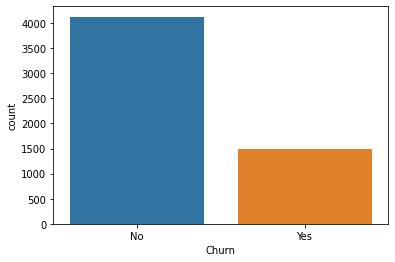

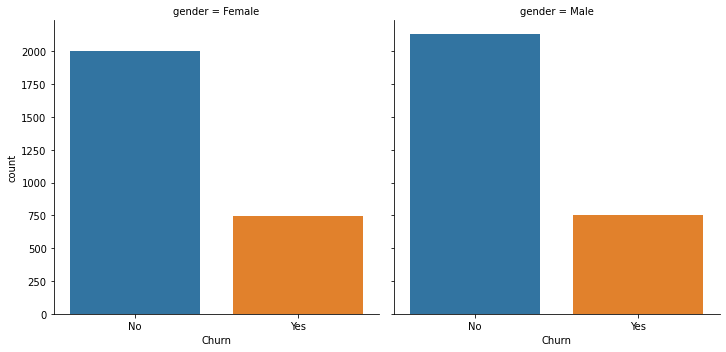

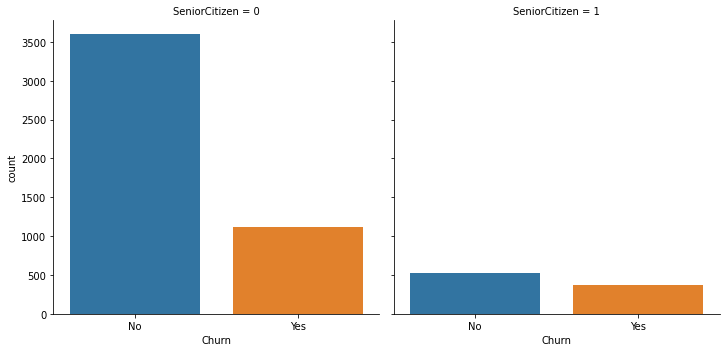

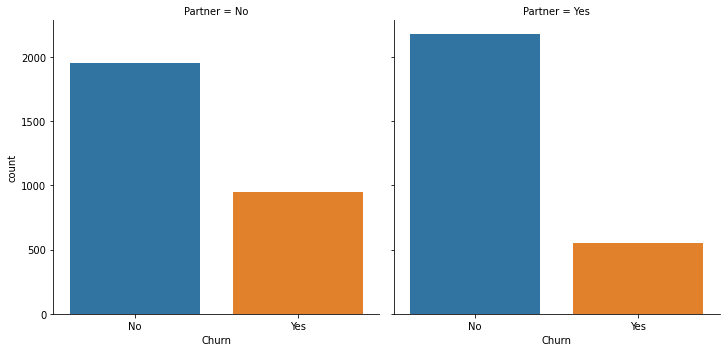

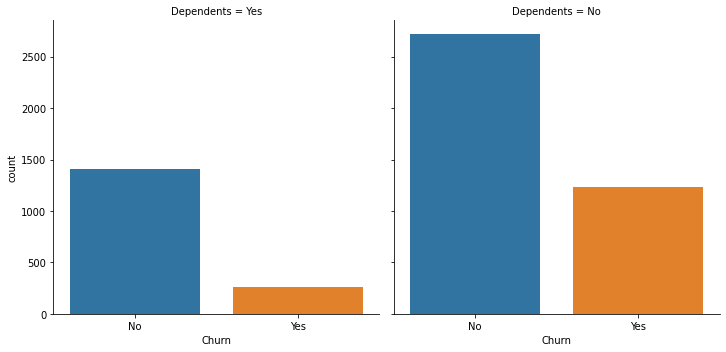

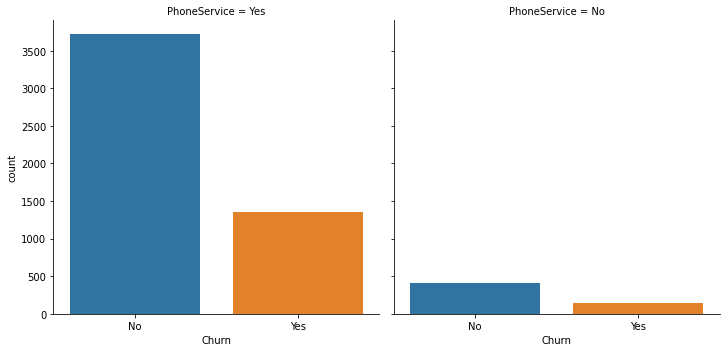

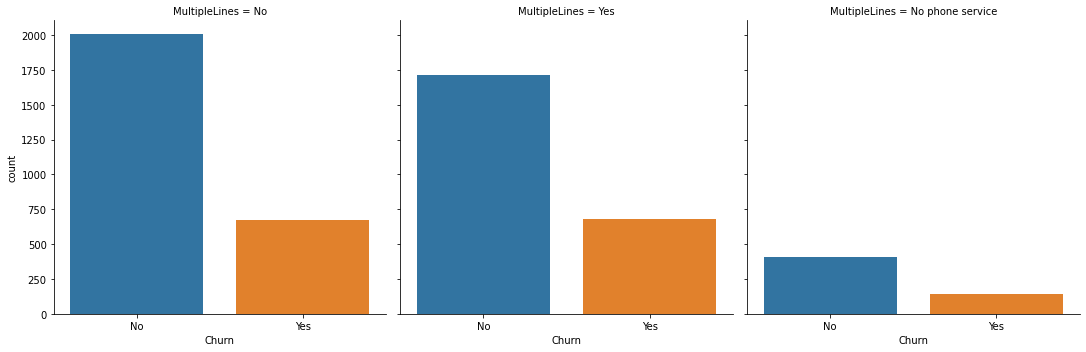

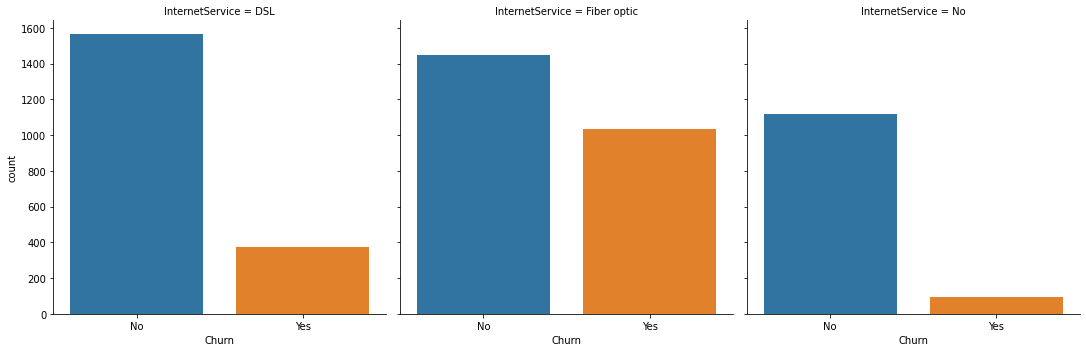

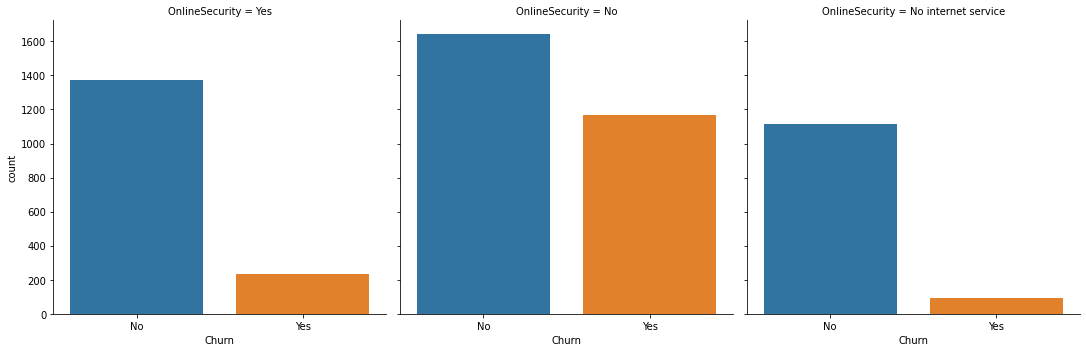

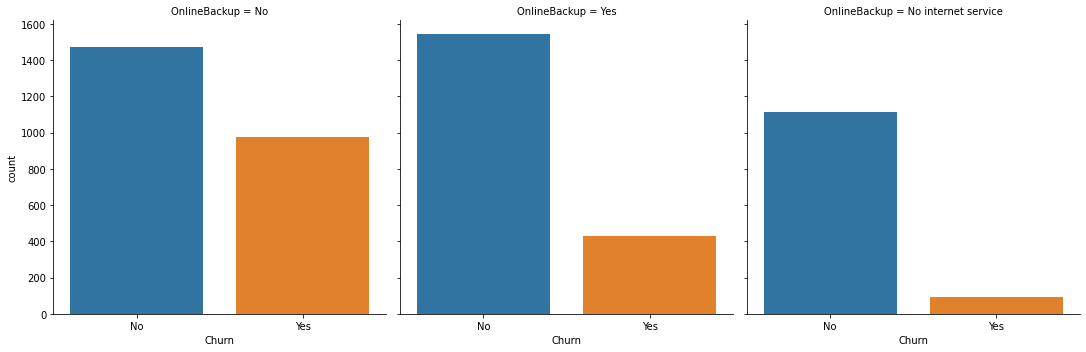

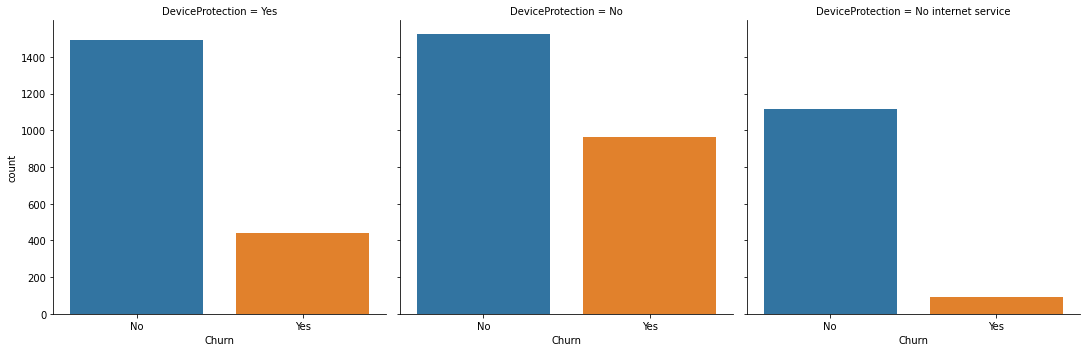

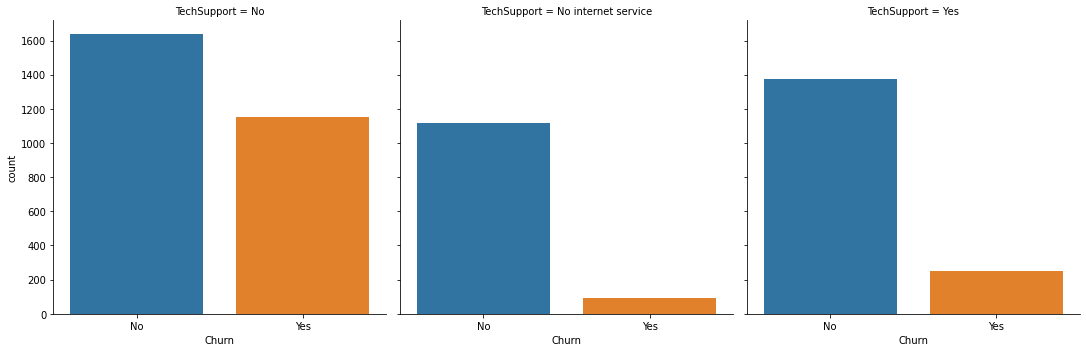

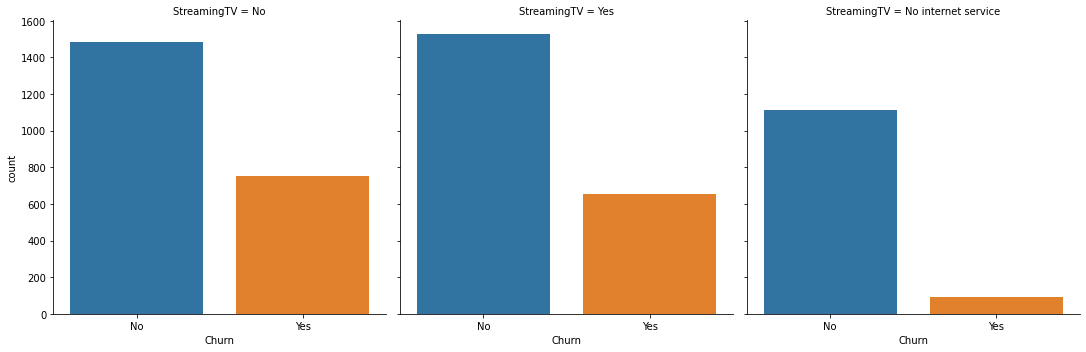

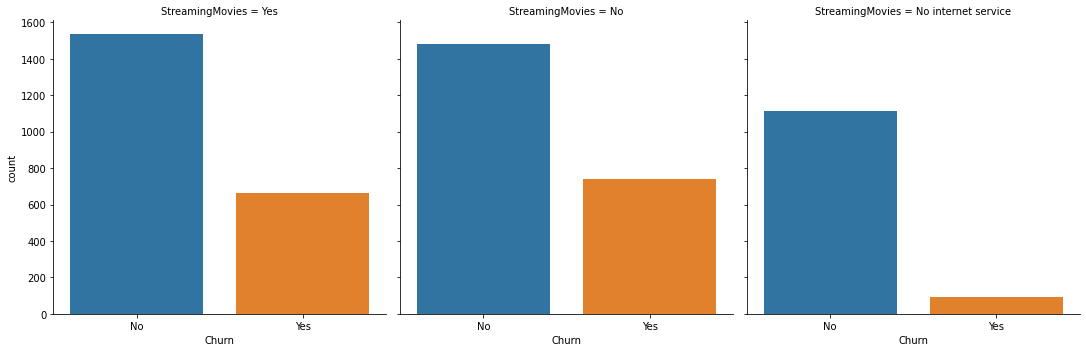

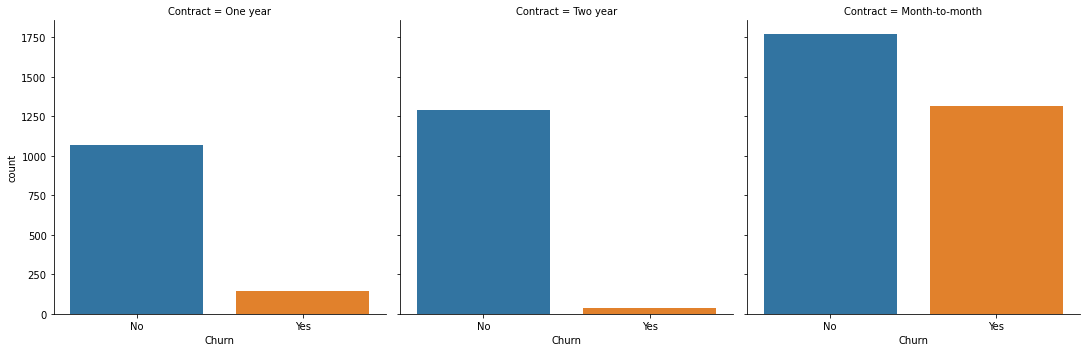

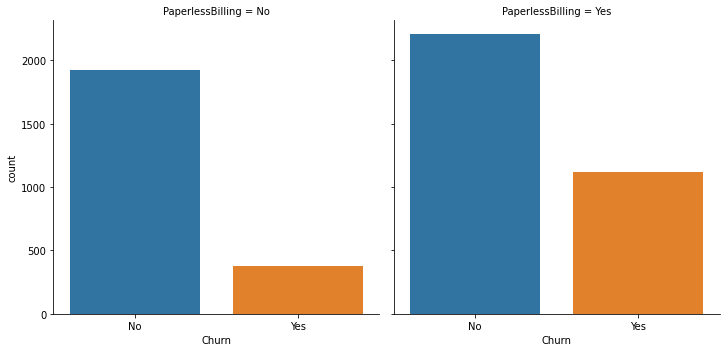

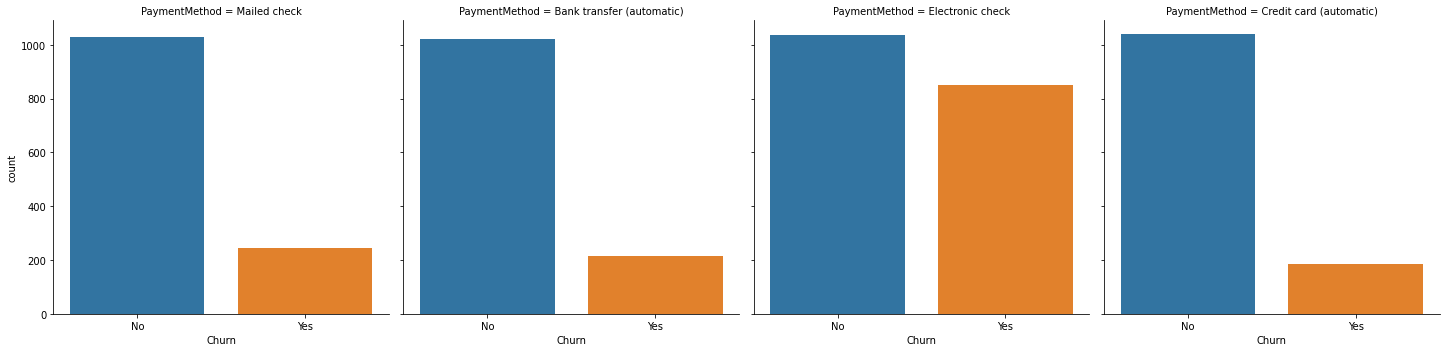

In [98]:
nonclass_features = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']

plot = sb.countplot(dataframe['Churn'])
plt.show()

for elem in dataframe:
  if elem not in nonclass_features:
    plot = sb.catplot(x = 'Churn', col = elem, data = dataframe, kind = 'count')
  plt.show()

Sembra che diverse features non influenzino la decisione, per cui verranno rimosse

In [99]:
# pop_features = []
pop_features = ['gender', 'Partner', 'PhoneService' ]
# pop_features = ['gender', 'tenure','PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for elem in pop_features:
  dataframe.pop(elem) 

La rete neurale lavora sfruttando i numeri e non le stringhe. Per questo motivo conviene trasformare ogni colonna che contiene stringhe in numeri interi che rappresentino la classe dell'elemento corrispondente. 

In [100]:
for elem in dataframe:
  if type(dataframe[elem][1]) is str:
    dataframe[elem] = pd.Categorical(dataframe[elem])
    dataframe[elem] = getattr(dataframe, elem).cat.codes

Ora trasformiamo tutto in float64, il tipo che verrà utilizzato successivamente

In [101]:
for elem in dataframe:
  dataframe[elem] = dataframe[elem].astype('float')

# dataframe = normalize(dataframe)

Ed ecco cosa contiere il nostro dataframe ora:

In [102]:
dataframe.head()

,Churn,SeniorCitizen,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.0,0.0,1.0,21.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,3.0,64.85,491.0
1,0.0,0.0,0.0,54.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0,97.20,3510.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,23.45,1565.0
3,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.20,1626.0
5,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,69.55,3548.0


In [103]:
dataframe.dtypes

Churn               float64
SeniorCitizen       float64
Dependents          float64
tenure              float64
MultipleLines       float64
InternetService     float64
OnlineSecurity      float64
OnlineBackup        float64
DeviceProtection    float64
TechSupport         float64
StreamingTV         float64
StreamingMovies     float64
Contract            float64
PaperlessBilling    float64
PaymentMethod       float64
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [104]:
dataframe.describe()

,Churn,SeniorCitizen,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.00000,5624.000000,5624.000000,5624.000000,5624.000000
mean,0.266003,0.161095,0.297475,32.430654,0.949147,0.870733,0.785917,0.915007,0.900427,0.793030,0.989331,0.995733,0.68830,0.590683,1.569168,64.911620,2650.028094
std,0.441905,0.367652,0.457188,24.408029,0.948567,0.736370,0.859946,0.882112,0.880585,0.861685,0.886133,0.886187,0.82924,0.491752,1.066948,30.081601,1530.269334
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,18.250000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,35.800000,1295.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,2.000000,70.550000,2645.500000
75%,1.000000,0.000000,1.000000,55.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.00000,1.000000,2.000000,89.950000,3980.250000
max,1.000000,1.000000,1.000000,72.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,1.000000,3.000000,118.600000,5298.000000


# Classificatori

## Preparazione del classificatore

Utilizziamo per questo problema 3 tipologie di modello di classificatore diverse:

*   Decision Tree, un modello che costruisce un albero di decisione nel quale ogni nodo rappresenta una caratteristica dell'input ed ogni figlio una conseguenza della stessa.
*   Random Forest, un modello che costruisce diversi Decision Tree in maniera pseudocasuale (costruendo una foresta) per poi sfruttare l'aggregazione degli stessi per ottenere un risultato migliore.

In [105]:
train, test = train_test_split(dataframe, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

train_target = train.pop(target_label)
test_target = test.pop(target_label)

models = []
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())

4499 train examples
1125 test examples


## Addestramento

In [106]:
def fit(model):
  global train
  global train_target
  
  model.fit(train, train_target)

list(map(fit, models))

[None, None]

## Test

Vediamo come i tre modelli si comportano nel risolvere il problema


[DecisionTreeClassifier]: Test Accuracy 0.728


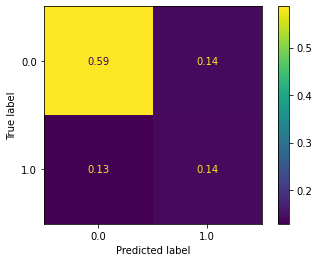

[RandomForestClassifier]: Test Accuracy 0.7822222222222223


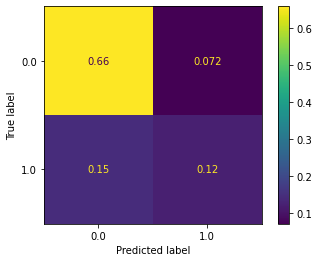

[None, None]

In [107]:
def predict(model):
  global test
  global test_target

  preds = model.predict(test)
  test_accuracy = metrics.accuracy_score(test_target, preds)
  print('[{}]: Test Accuracy {}'.format(type(model).__name__, test_accuracy))
  metrics.plot_confusion_matrix(model, test, test_target, normalize='all')
  plt.show()

list(map(predict, models))